In [2]:
#/default_exp app

In [3]:
#/export
from fastai.vision.all import *

## Step 1: Download images

In [4]:
from duckduckgo_search import ddg_images
from fastcore.all import *

def search_images(term, max_images=30):
    print(f"Searching for '{term}'")
    return L(ddg_images(term, max_results=max_images)).itemgot('image')

In [18]:
#NB: `search_images` depends on duckduckgo.com, which doesn't always return correct responses.
#    If you get a JSON error, just try running it again (it may take a couple of tries).
urls = search_images('bengal cat photos', max_images=1)
urls[0]

Searching for 'bengal cat photos'


'http://pulpbits.net/wp-content/uploads/2014/01/bengal-cat-domestic.jpg'

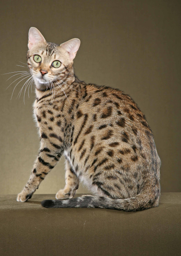

In [19]:
from fastdownload import download_url
dest = 'cat.jpg'
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

Searching for 'dog photos'


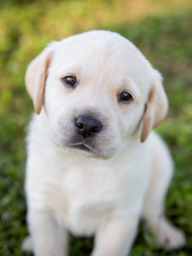

In [8]:
download_url(search_images('dog photos', max_images=1)[0], 'dog.jpg', show_progress=False)
Image.open('dog.jpg').to_thumb(256,256)

In [9]:
searches = 'dog','cat'
path = Path('dog_or_cat')
from time import sleep

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo'))
    sleep(10)  # Pause between searches to avoid over-loading server
    download_images(dest, urls=search_images(f'{o} running photo'))
    sleep(10)
    download_images(dest, urls=search_images(f'{o} sleeping photo'))
    sleep(10)
    resize_images(path/o, max_size=400, dest=path/o)

Searching for 'dog photo'
Searching for 'dog running photo'
Searching for 'dog sleeping photo'
Searching for 'cat photo'
Searching for 'cat running photo'
Searching for 'cat sleeping photo'


## Step 2: Training our model

In [11]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

1

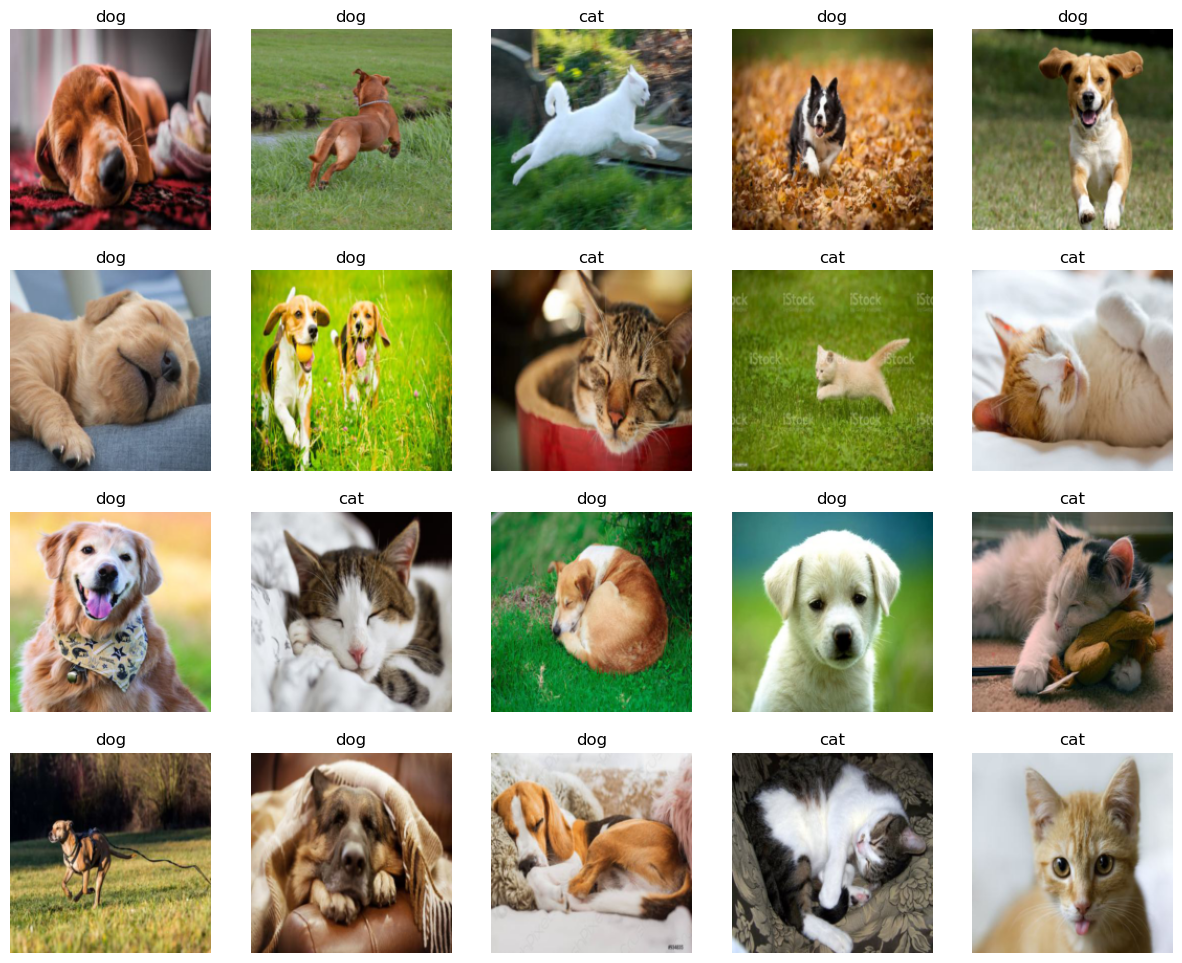

In [12]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=20)

In [13]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

/Users/joshai/mambaforge/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/joshai/mambaforge/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /Users/joshai/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,0.892186,0.548793,0.176471,00:16


epoch,train_loss,valid_loss,error_rate,time
0,0.240135,0.217273,0.029412,00:29
1,0.212491,0.157962,0.029412,00:22
2,0.154735,0.158219,0.029412,00:19


## Step 3: Testing and exporting our model

In [20]:
cat_or_dog,_,probs = learn.predict(PILImage.create('cat.jpg'))
print(f"This is a: {cat_or_dog}.")
print(f"Probability it's a {cat_or_dog}: {probs[0]:.4f}")

This is a: cat.
Probability it's a cat: 1.0000


In [21]:
learn.export()

## Step 4: Creating a webpage to interface with the model

In [4]:
#/export
learn = load_learner('export.pkl')

In [3]:
%time learn.predict(PILImage.create('cat.jpg'))

CPU times: user 457 ms, sys: 126 ms, total: 583 ms
Wall time: 580 ms


('cat', TensorBase(0), TensorBase([1.0000e+00, 1.0831e-06]))

In [66]:
# alternative to classify_image (from the gradio guide)
# to run this change gr.interface(fn=predict,....

labels = learn.dls.vocab

def predict(img):
    img = PILImage.create(img)
    pred,pred_idx,probs = learn.predict(img)
    return {labels[i]: float(probs[i]) for i in range(len(labels))}

In [5]:
#/export
categories = ('Cat','Dog')

def classify_image(img):
    pred,idx,probs = learn.predict(img)
    return dict(zip(categories, map(float,probs)))

In [61]:
classify_image(PILImage.create('cat.jpg'))

{'Cat': 0.999998927116394, 'Dog': 1.0831245162989944e-06}

In [6]:
#/export
title = "Cat or Dog Classifier"
description = "This model will tell you how much your cat looks like a dog... or not"
interpretation='default'
article="<p style='text-align: center'><a href='https://tmabraham.github.io/blog/gradio_hf_spaces_tutorial' target='_blank'>Blog post</a></p>"
examples = ['cat.jpg','dog.jpg']
enable_queue=True

In [7]:
#/export
import gradio as gr

intf = gr.Interface(fn=classify_image,
             inputs=gr.inputs.Image(shape=(512, 512)),
             outputs=gr.outputs.Label(num_top_classes=3),
             title=title,
             description=description,
             article=article,
             examples=examples,
             interpretation=interpretation,
             enable_queue=enable_queue)
intf.launch()

/Users/joshai/mambaforge/lib/python3.10/site-packages/gradio/inputs.py:257: UserWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  warnings.warn(
/Users/joshai/mambaforge/lib/python3.10/site-packages/gradio/deprecation.py:40: UserWarning: `optional` parameter is deprecated, and it has no effect
  warnings.warn(value)
/Users/joshai/mambaforge/lib/python3.10/site-packages/gradio/outputs.py:197: UserWarning: Usage of gradio.outputs is deprecated, and will not be supported in the future, please import your components from gradio.components
  warnings.warn(
/Users/joshai/mambaforge/lib/python3.10/site-packages/gradio/deprecation.py:40: UserWarning: The 'type' parameter has been deprecated. Use the Number component instead.
  warnings.warn(value)
/Users/joshai/mambaforge/lib/python3.10/site-packages/gradio/deprecation.py:40: UserWarning: `enable_queue` is deprecated in `Interface()`, please use it with

Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


## Step 5: Export notebook into script

In [9]:
from nbdev.export import nb_export
nb_export('fastpg1.ipynb','.')